# Are word counts correlated with profit margin?
### This is a simplistic experiment but could be more robust

### Software (Python jupyter Pandas) is industry standard



In [ ]:
%pip install "calcbench-api-client[Pandas, Backoff, BeautifulSoup]" tqdm scipy seaborn

In [1]:
import pandas as pd

from tqdm.notebook import tqdm
import qgrid

from scipy.special import expit
import seaborn as sns
from collections import Counter
from typing import Iterable

import calcbench as cb


cb.enable_backoff()
tqdm.pandas(desc="progress")

## Get the documents and build dictionaries of word counts
### Calcbench extracts MD&A from 10-K/Qs

In [ ]:
tickers = cb.tickers(index="SP500")  # can use any list of tickers

In [2]:
#disclosure_embeddings = pd.read_pickle(
#    r"C:\Users\andre\Dropbox (Calcbench)\andrew\sp_500_tokenize_embeddings.pkl"
#)

disclosure_names = ["ManagementsDiscussionAndAnalysis"] # full list available @ 

with tqdm() as progress_bar:
    disclosures = cb.document_dataframe(
        company_identifiers=tickers,
        disclosure_names=disclosure_names,
        all_history=True,
        period_type="annual",
        progress_bar=progress_bar,
        # entire_universe=True,
    )
    
def get_contents(d):
    try:
        return d.get_contents_text()
    except Exception as e:
        print(f"Exception getting {d} \n{e}")


disclosure_contents = disclosures.progress_applymap(
    get_contents, na_action="ignore"
).fillna("")

disclosure_embeddings = disclosure_contents.progress_applymap(
    lambda c: Counter(word.lower() for word in nltk.word_tokenize(c))
)

## Find occurrences of terms

In [84]:
terms = ["inflation", "supply", "inflationary"]

def distance(word_counts: Counter, category_words: Iterable[str]):
    return sum(count for word, count in word_counts.items() if word in category_words)

category_distances = disclosure_embeddings.progress_applymap(
    lambda word_counts: distance(word_counts, terms)
)

progress:   0%|          | 0/14940 [00:00<?, ?it/s]

## Get standardized Profit Margin
### Can get any of the metrics from https://www.calcbench.com/home/standardizedmetrics

In [8]:

metric = "GrossProfitMargin"  # Can use any of the calcbench standardized metrics

profit_margin = cb.standardized_data(
    company_identifiers=tickers,
    metrics=[metric],
    all_history=True,
    period_type="annual",
)[metric]

In [10]:
SIC_code = cb.standardized_data(
    company_identifiers=tickers,
    metrics=["SIC_code"],
    all_history=True,
    period_type="annual",
)

In [61]:
two_digit_SIC_codes = pd.to_numeric(
    SIC_code["SIC_code"].iloc[0] // 100, downcast="integer"
).astype(str)
two_digit_SIC_codes.name = "SIC_Code"

In [14]:
md_a_diff = (
    category_distances.ManagementsDiscussionAndAnalysis
    - category_distances.ManagementsDiscussionAndAnalysis.shift()
)

In [21]:
profit_margin_change = profit_margin - profit_margin.shift()

In [105]:
total_word_counts

disclosure_type_name ManagementsDiscussionAndAnalysis                       \
ticker                                              A    AAL    AAP   AAPL   
period                                                                       
2007                                                0      0      0      0   
2008                                                0      0      0      0   
2009                                            15121      0      0  12004   
2010                                            14560  16431  10717  10966   
2011                                            15897  19394   9699  10398   
2012                                            17136  14656  10146  11859   
2013                                            16511  96161  11287  10978   
2014                                            18412  30244  11890  10789   
2015                                            16525  24483  11775  10337   
2016                                            16178  18088  11371  10101   
2017                                            15848  18992   6647  10395   
2018                                            16261  17960   6032   9871   
2019                                            17122  11839   5412   5810   
2020                                            17526  14669   6369   5450   
2021                                                0      0      0      0   

disclosure_type_name                                                          \
ticker                 ABBV    ABC   ABMD    ABT    ACN   ADBE    ADI    ADM   
period                                                                         
2007                      0      0      0      0      0      0      0      0   
2008                      0      0   9643      0      0      0      0      0   
2009                      0  15342  10833   9140      0  13723  11903      0   
2010                      0  11877   9197  12028  15077  16510  11154   7975   
2011                      0  12203      0  15332  13139  14616  12033   9356   
2012                      0  12131   6808  13965  12656  14538  11298  14494   
2013                  11193  13755   7812  11625  13423  14638  11088  14074   
2014                  13182  13998   9180  13776  13080  15265  11869  14580   
2015                  13901  15147   7845  14031  12024  14422  10334  13867   
2016                  12101  14308   7437  15856  12688  13714  11345  13453   
2017                  11431  14195   6589  17093  10615  12654  11554  13263   
2018                  10753  15198   6970  15952  10759  11134  12499  13759   
2019                  10759  14725   5785  15251   8775  10100  12463  13348   
2020                   9837  14902   6752  12922   7567  10476  10335  14051   
2021                      0      0   6285      0      0      0      0      0   

disclosure_type_name                                                          \
ticker                  ADP   ADSK    AEE    AEP    AES    AFL    AIG    AIZ   
period                                                                         
2007                      0      0      0      0      0      0      0      0   
2008                      0      0      0      0      0      0      0      0   
2009                      0      0  40987    182  32527  21608  24556  28758   
2010                  15022  14879  38367    179  34151  22241  95200  25110   
2011                  36477  15215  36723  28933  30326  31885   1535  25899   
2012                  14776  14710     15    125  29647  30051  82158  24166   
2013                  14337  15549  29567    125  26158  28715  89082  23536   
2014                  14851  16883  26882    119  31092  27824  87853  24230   
2015                  12404  17107  26623    119  31061  29479  90759  21968   
2016                  12294  19071  28424    119  26079  23523  75980  19282   
2017                  13135  17741  27680    124  25459  23850  75667  18550   
2018                  13129  17195

In [103]:
category_distances.ManagementsDiscussionAndAnalysis / total_word_counts

disclosure_type_name ManagementsDiscussionAndAnalysis                      \
ticker                                              A       AAL       AAP   
period                                                                      
2007                                              NaN       NaN       NaN   
2008                                              NaN       NaN       NaN   
2009                                         0.000000       NaN       NaN   
2010                                         0.000000  0.000183  0.000840   
2011                                         0.000252  0.000103  0.001650   
2012                                         0.000117  0.000205  0.000986   
2013                                         0.000000  0.000073  0.000797   
2014                                         0.000054  0.000033  0.001009   
2015                                         0.000182  0.000041  0.000679   
2016                                         0.000124  0.000055  0.001231   
2017                                         0.000126  0.000053  0.001504   
2018                                         0.000123  0.000111  0.001989   
2019                                         0.000117  0.000000  0.001848   
2020                                         0.000228  0.000000  0.001884   
2021                                              NaN       NaN       NaN   

disclosure_type_name                                                         \
ticker                    AAPL      ABBV       ABC ABMD       ABT       ACN   
period                                                                        
2007                       NaN       NaN       NaN  NaN       NaN       NaN   
2008                       NaN       NaN       NaN  0.0       NaN       NaN   
2009                  0.000250       NaN  0.000391  0.0  0.000109       NaN   
2010                  0.000274       NaN  0.000505  0.0  0.000083  0.000066   
2011                  0.000289       NaN  0.000410  NaN  0.000065  0.000152   
2012                  0.000000       NaN  0.000412  0.0  0.000286  0.000158   
2013                  0.000182  0.000089  0.000654  0.0  0.000430  0.000149   
2014                  0.000185  0.000076  0.000572  0.0  0.000436  0.000153   
2015                  0.000193  0.000072  0.000528  0.0  0.000356  0.000166   
2016                  0.000198  0.000083  0.000489  0.0  0.000315  0.000158   
2017                  0.000192  0.000087  0.000493  0.0  0.000293  0.000188   
2018                  0.000203  0.000093  0.000395  0.0  0.000188  0.000186   
2019                  0.000172  0.000093  0.000407  0.0  0.000000  0.000228   
2020                  0.000183  0.000508  0.000470  0.0  0.000000  0.000264   
2021                       NaN       NaN       NaN  0.0       NaN       NaN   

disclosure_type_name                                                    \
ticker                    ADBE       ADI       ADM  ADP ADSK       AEE   
period                                                                   
2007                       NaN       NaN       NaN  NaN  NaN       NaN   
2008                       NaN       NaN       NaN  NaN  NaN       NaN   
2009                  0.000073  0.000084       NaN  NaN  NaN  0.000756   
2010                  0.000061  0.000090  0.000251  0.0  0.0  0.000808   
2011                  0.000068  0.000083  0.000428  0.0  0.0  0.000926   
2012                  0.000069  0.000089  0.000483  0.0  0.0  0.000000   
2013                  0.000068  0.000090  0.000497  0.0  0.0  0.000406   
2014                  0.000066  0.000084  0.000617  0.0  0.0  0.000409   
2015                  0.000069  0.000097  0.000577  0.0  0.0  0.000451   
2016                  0.000073  0.000088  0.000669  0.0  0.0  0.000352   
2017                  0.000079  0.000087  0.000452  0.0  0.0  0.000217   
2018                  0.000090  0.000080  0.000363  0.0  0.0  0.000254   
2019                  0.000099  0.000080  0.000300  0.0  0.0  0.000263   
2020  

In [108]:
d = (
    pd.DataFrame(
        data={
            "profit_margin": expit(profit_margin.stack()),
            "inflation_count": (category_distances.ManagementsDiscussionAndAnalysis / total_word_counts.ManagementsDiscussionAndAnalysis).stack(),
        }
    )
    .swaplevel()
    .sort_index()
)

## Correlation of period profit margin change and presence inflation terms

In [113]:
sns.scatterplot?

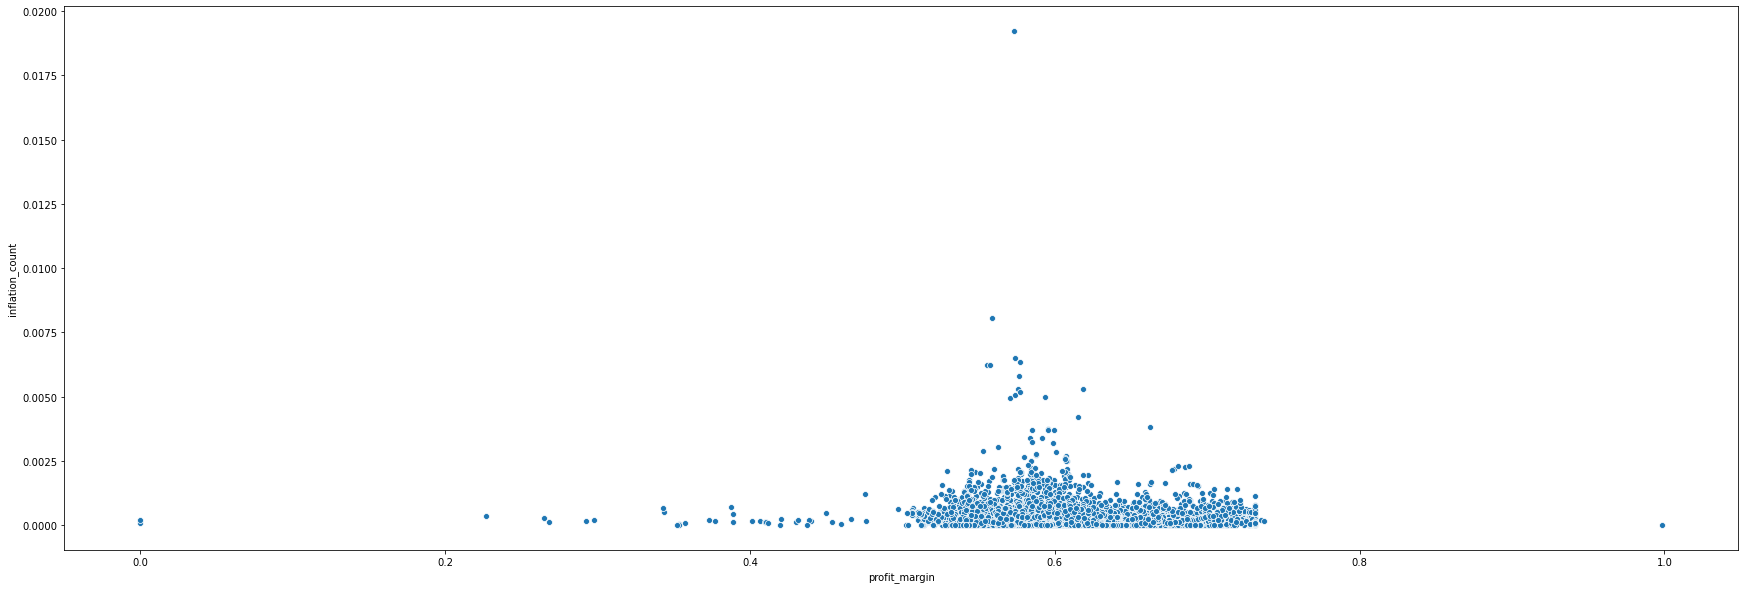

In [121]:
g = sns.scatterplot(x="profit_margin", y="inflation_count", data=d)
g.figure.set_figheight(10)
g.figure.set_figwidth(30)

In [118]:
g.figure.set_figheight(20)

## How has term count changed over time?

In [75]:
total_word_counts = disclosure_embeddings.progress_applymap(lambda w: sum(w.values()))
tf_document_length = category_distances / total_word_counts
industry_averages = tf_document_length.groupby(by=group, axis=1).mean()

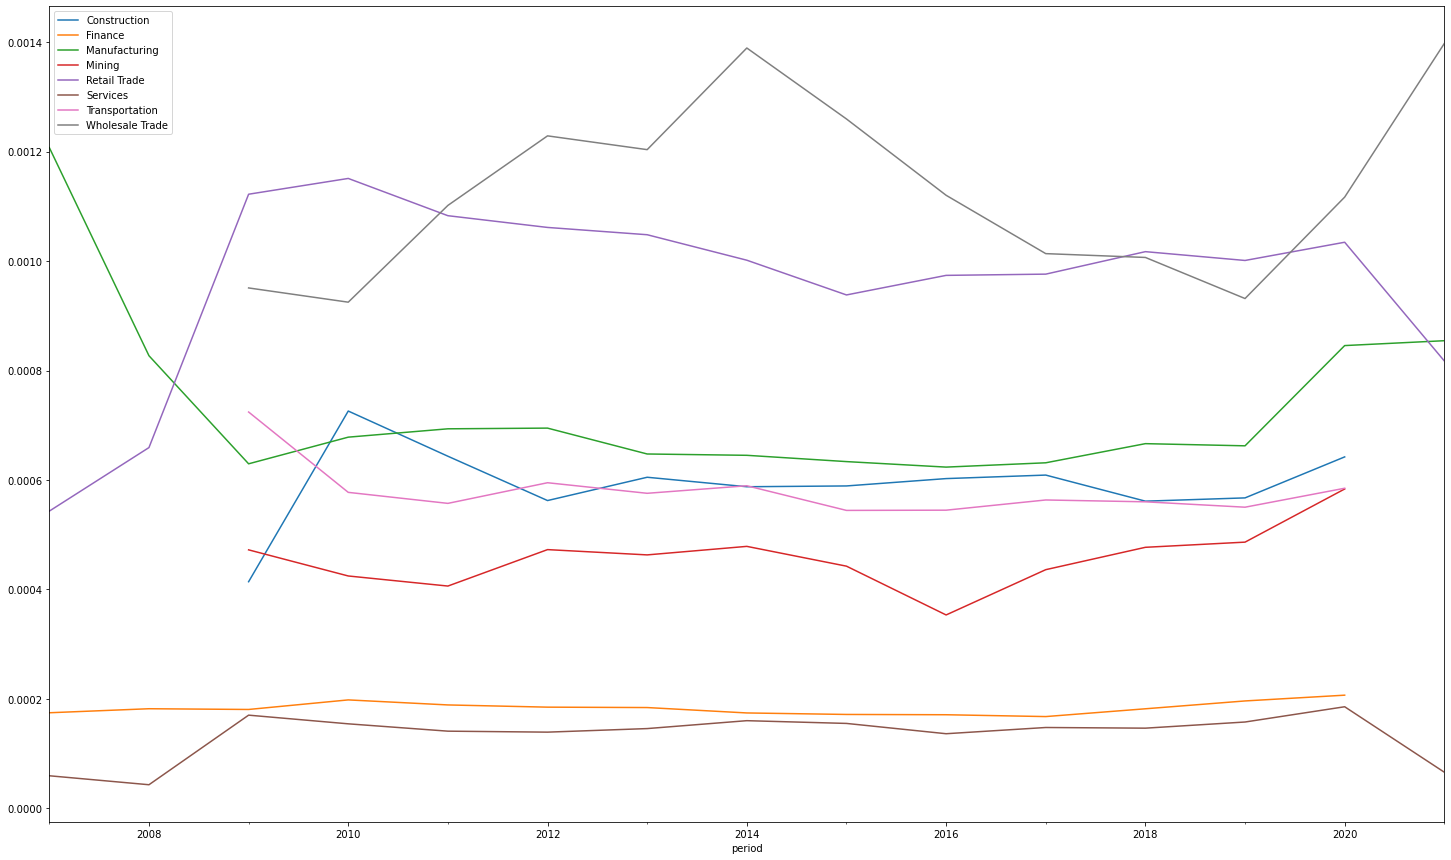

In [86]:
industry_averages.plot(figsize=(25, 15))

In [ ]:
def group(c):
    try:
        two_digit_SIC_code = int(two_digit_SIC_codes[c[1]])
    except KeyError:
        return None
    else:
        if two_digit_SIC_code < 9:
            return "Agriculture"
        elif 10 <= two_digit_SIC_code <= 14:
            return "Mining"
        elif 15 <= two_digit_SIC_code <= 17:
            return "Construction"
        elif 20 <= two_digit_SIC_code <= 39:
            return "Manufacturing"
        elif 40 <= two_digit_SIC_code <= 49:
            return "Transportation"
        elif 50 <= two_digit_SIC_code <= 51:
            return "Wholesale Trade"
        elif 52 <= two_digit_SIC_code <= 59:
            return "Retail Trade"
        elif 60 <= two_digit_SIC_code <= 67:
            return "Finance"
        elif 70 <= two_digit_SIC_code <= 89:
            return "Services"